# Домашнее задание №3

<span style="color: red; font-size: 14pt">Дедлайн: 20 марта 23:59</span>

Машинное обучение, ФИВТ, Весна 2018

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2018_fall <номер_группы> <фамилия>``, к примеру -- ``ML2018_fall 596 ivanov``
- Выполненное дз сохраните в файл ``ML2018_<фамилия>_<группа>_task<номер задания>.ipnb``, к примеру -- ``ML2018_ivanov_596_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com`` (или в телеграм-канал)
- Укажите тему письма в следующем формате ``ML2018_fall Question <Содержание вопроса>``

--------
- **PS1**: Используются автоматические фильтры, мы не найдем ваше дз, если вы укажете тему письма в неправильном формате.
- **PS2**: Просроченный дедлайн снижает максимальный вес задания по формуле, указнной на первом семинаре

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn
import sklearn.base
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

## Часть 1. Теоретические задачи

##### 30% баллов за задание, оценочное время выполнения 30 минут

### Задача 1 (10% баллов)

Предположим, что мы решаем задачу бинарной классификации и что у нас есть три алгоритма $b_1(x)$, $b_2(x)$ и $b_3(x)$, каждый из которых ошибается с вероятностью p. Мы строим композицию взвешенным голосованием: алгоритмам присвоены значимости $w_1$, $w_2$ и $w_3$, и для вынесения вердикта суммируются значимости алгоритмов, проголосовавших за каждый из классов:

$$a_0 = \sum_{i=1}^3 w_i [b_i(x)=0]$$
$$a_1 = \sum_{i=1}^3 w_i [b_i(x)=1]$$


Объект $x$ относится к классу, для которого такая сумма оказалась максимальной. Например, если первые два алгоритма голосуют за класс $0$, а третий — за класс $1$, то выбирается класс $0$, если $w_1 + w_2 > w_3$, и класс $1$ в противном случае. Какова вероятность ошибки такой композиции этих трех алгоритмов, если:
1. $w_1 = 0.2, w_2 = 0.3, w_3 = 0.2$;
2. $w_1 = 0.2, w_2 = 0.5, w_3 = 0.2$? 

**Решение:** Для начала заметим, что $a_i  = w_1 + w_2 + w_3 - a_{1-i}$ Более того, если разделить $a_i$ на сумму $w_i$, то видно, что итоговый ответ есть I(a_1 > 0.5) (равенство половине не достигается на этих конкретных $w_i$)

Считая, что верный класс 1, переберём комбинации ответов, при которых алгоритм ошибается:

In [178]:
for i1 in [0, 1]:  # проще написать код, чем перебрать 8 вариантов ручкам
    for i2 in [0, 1]:
        for i3 in [0, 1]:
            s = i1 * 0.2 + i2 * 0.2 + i3 * 0.3
            if (s < (0.2 + 0.2 + 0.3) / 2):
                print(i1, i2, i3)

0 0 0
0 0 1
0 1 0
1 0 0


Считая алгоритмы независимыми, получаем случай когда ошиблись все ($p^3$) и три случая когда ошиблись 2 из 3 ($3 (1 - p)p^2$). Итого $p^2 (p + 3(1-p)) = p^2 (3 - 2p)$

Заметим, что если верный класс 0, то ничего не изменится (вообще, это очевидно):

In [179]:
for i1 in [0, 1]:
    for i2 in [0, 1]:
        for i3 in [0, 1]:
            s = i1 * 0.2 + i2 * 0.2 + i3 * 0.3
            if (s > (0.2 + 0.2 + 0.3) / 2):
                print(i1, i2, i3)

0 1 1
1 0 1
1 1 0
1 1 1


**Итоговая вероятность**: $p^2 (3 - 2p)$

____________
Повторим для второго пункта:

In [180]:
for i1 in [0, 1]:  # Верный класс = 1
    for i2 in [0, 1]:
        for i3 in [0, 1]:
            s = i1 * 0.2 + i2 * 0.2 + i3 * 0.5
            if (s < (0.2 + 0.2 + 0.5) / 2):
                print(i1, i2, i3)

0 0 0
0 1 0
1 0 0
1 1 0


In [181]:
for i1 in [0, 1]:  # Верный класс = 0
    for i2 in [0, 1]:
        for i3 in [0, 1]:
            s = i1 * 0.2 + i2 * 0.2 + i3 * 0.5
            if (s > (0.2 + 0.2 + 0.5) / 2):
                print(i1, i2, i3)

0 0 1
0 1 1
1 0 1
1 1 1


Имеем один случай, когда ошиблись все ($p^3$), два случая, когда ошиблись 2 из 3 ($2 p^2(1-p)$), один случай, когда ошибся 1 из 3 ($(1 - p)^2p$). Итого: $p(p^2 + 2 (p(1-p)) + (1-p)^2) = p(2p - p^2 + (1-p)^2) = p(2p - p^2 + 1 - 2p + p^2) = p$

**Итоговая вероятность**: $p$ (короче говоря, выборы должны быть без преимущественного права, поскольку, при p < 0.5 (не случайное предсказание) вероятность ошибки в первом случае меньше)

### Задача 2 (10% баллов)

Рассмотрим задачу бинарной классификации. Будем считать, что все алгоритмы из базового семейства возвращают ответы из отрезка $[0,1]$, которые можно интерпретировать как вероятности принадлежности объектов классу $1$. В качестве функции потерь возьмем отрицательный логарифм правдоподобия:
$$L(y,z) = -(y \log{z}+(1-y)\log{(1-z)})$$
В формуле $y$ - правильный ответ, $z$ - ответ алгоритма. Выпишите формулы для поиска базовых алгоритмов $b_n$ и коэффициентов $\gamma_n$ в градиентном бустинге.

**Решение:** Как было сказано на семинаре, нужно просто выписать алгоритм градиентного бустинга специфичный для этой функции

$$
\frac{\partial L(y, z)}{\partial x} = \frac{1- y}{1 - z} - \frac{y}{z}
$$

Соответственно, если мы подставляем сигмоду для классификации, как говорилось на семинаре, получим:

$$
\frac{\partial L(y, \sigma(z))}{\partial x} =
(\frac{1- y}{1 - \sigma(z)} - \frac{y}{\sigma(z)}) \frac{\partial \sigma(z)}{\partial z} = 
(\frac{1- y}{1 - \sigma(z)} - \frac{y}{\sigma(z)}) \frac{-e^z}{(1 + e^z)^2}
$$

Итого:

**Init**
<font color="white">___</font>$w_i = \frac{1}{N}, \forall{i} \in 1..N$

**for m in 1..M:**

<font color="white">___</font>$\nabla Q$ = [$\frac{\partial L}{\partial x}(y[i], F_{m-1}(X[i]))$ for i in 1...N]

<font color="white">___</font>$b_n$ = Model.fit(X, $\nabla Q$)

<font color="white">___</font>$\gamma_n$ = ${argmin}_{b \in R} \sum\limits_{i = 1}^{N} L(F_{m-1}(X[i]) + b \nabla Q_i)$

<font color="white">___</font>$F_n = F_{n-1} + \gamma_n b_n$  # при вызове $F_n(x)$ вызываем $\sum\limits_{i=1}^{n}b_n(x)\gamma_n$

# Задача 3 (10% баллов)

Известно, что на $n$-й итерации двухклассового метода AdaBoost
был выбран базовый классификатор, допускающий ошибку только на одном объекте $x_j$. Найдите нормированный вес $w_j^{(n+1)}$ при этом объекте на следующей итерации.

**Решение:** Пусть $G_n$ совершает ошибку только на j-ом обьекте. 
Веса в AdaBoost пересчитываются так:

$$
err_n = \frac{\sum_{i=1}^{N}w_i I(y_i \neq G_n(x_i))}{\sum_{i=1}^{N}w_i} \\ 
\alpha_n = log(\frac{1- err_n}{err_n}) \\
w_i := w_i exp(\alpha_n I(y_i \neq G_n(x_i)), \forall i \in {1..N}
$$ 

Тогда получаем, что:
$$
err_n = \frac{w_j}{\sum_{i=1}^{N}w_i} \\
\Rightarrow a_n = log((\frac{\sum_{i=1, i \neq j}^{N}w_i}{\sum_{i=1}^{N}w_i}) / (\frac{w_j}{\sum_{i=1}^{N}w_i})) =
log(\frac{\sum_{i=1, i \neq j}^{N}w_i}{w_j}) \\
$$
Далее для всех $i \neq j : w_i := w_i exp(0) = w_i$. Для $w_j$:
$$
(w_j^{n+1} \equiv ) w_j := w_j exp(\alpha_n) = w_j exp(log(\frac{1 - err_n}{err_n})) = w_j \frac{\sum_{i=1, i \neq j}^{N}w_i}{w_j} =
\sum_{i=1, i \neq j}^{N}w_i
$$


Соответственно, если отномировать веса, то получим:
$$1 - \frac{w_j}{\sum {w_i}}$$

## Часть 2. Random Forest

##### 70% баллов за задание, оценочное время выполнения 3 часа

### Реализация (40%)

**Необходимо реализовать класс `RandomForest`** (для решения задачи классификации)

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    - `num_trees` - количество деревьев в лесе;
    - `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    - `max_features` - количество признаков, принимаемое к рассмотрению при разбиении (аналогичный параметр есть в sklearn имплементации). Параметр может принимать значения:
        - int - тогда рассматриваем max_features признаков при каждом разбиении;
        - float - max_features обозначает процент, int(max_features * n_features) признаков рассматривается при каждом разбиении;
        - “sqrt” - max_features=sqrt(n_features);
        - “log2” - max_features=log2(n_features);
        - None - max_features=n_features;
    - `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', по умолчанию - 'gini'); функции с подсчетом энтропийного и критерия Джини можно взять из предыдущего дз;
    
- класс имеет методы `fit` и `predict`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `RandomForest`, представляющий собой Random Forest, обученный по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов;

In [5]:
def bagging(X, y, size):
    """ Gives (size) bootstapped samples from (X, y)"""
    indexes = np.random.choice(np.arange(X.shape[0]), size=(size, X.shape[0]))
    return X[indexes, :], y[indexes]

In [41]:
def lazy_rsm(feature_cnt, cnt):
    indexes = np.random.choice(np.arange(feature_cnt), size=cnt, replace=False)
    return indexes

In [47]:
X = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
])

y = np.array([1, 2, 3])

lazy_rsm(X.shape[1], 2)

array([2, 1])

In [143]:
def get_features_count(max_features, n):
    if type(max_features) == int:
        return max_features
    elif  type(max_features) == float:
        return int(max_features * n)
    elif max_features == "sqrt":
        return int(n ** 0.5)
    elif max_features == "log2":
        return int(np.log2(n))
    elif max_features is None:
        return n
    else:
        raise RuntimeError

In [49]:
bagging(X, y, 5)

(array([[[1, 2, 3],
         [7, 8, 9],
         [4, 5, 6]],
 
        [[1, 2, 3],
         [7, 8, 9],
         [1, 2, 3]],
 
        [[7, 8, 9],
         [1, 2, 3],
         [1, 2, 3]],
 
        [[4, 5, 6],
         [4, 5, 6],
         [4, 5, 6]],
 
        [[4, 5, 6],
         [7, 8, 9],
         [1, 2, 3]]]), array([[1, 3, 2],
        [1, 3, 1],
        [3, 1, 1],
        [2, 2, 2],
        [2, 3, 1]]))

In [166]:
class RandomForest(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, num_trees, max_depth = np.inf, max_features = None, criterion = "gini", lazy_rsm = False):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []
        
        self.lazy_rsm = lazy_rsm 
        self.trees_features = []
    
    def fit(self, X_train, y_train):
        '''
        Create trees here, using bagging and RSM.
        '''
        self.trees = []
        self.trees_feature_indexes = []  # just for lazy RSM
            
        X_sampled, y_sampled = bagging(X_train, y_train, self.num_trees)
        
        for i in range(self.num_trees):
            tree = DecisionTreeClassifier(criterion=self.criterion,
                                          max_depth=self.max_depth if not np.isinf(self.max_depth) else None,
                                          max_features=self.max_features if not self.lazy_rsm else None)
            if self.lazy_rsm:
                features = lazy_rsm(X_train.shape[1], get_features_count(self.max_features, X.shape[1]))
                tree.fit(X_sampled[i][:, features], y_sampled[i])
                self.trees_features.append(features)
            else:
                tree.fit(X_sampled[i], y_sampled[i])
                
            self.trees.append(tree)
        return self
    
    def predict(self, X_test):
        '''
        Predict the label here using your grown trees.
        '''
        # y_pred = np.empty(X_test.shape[0])  # <--- зачем
        # print(y_pred.dtype) # float64, будут проблемы
        ensemble_prediciton = []
        for i in range(self.num_trees):
            if self.lazy_rsm:
                features = self.trees_features[i]
                ensemble_prediciton.append(self.trees[i].predict(X_test[:, features]))
            else:
                ensemble_prediciton.append(self.trees[i].predict(X_test))
        ensemble_prediciton = np.array(ensemble_prediciton)
        # print(ensemble_prediciton)
        
        predictions = []
        for i in range(X_test.shape[0]):
            uniqs, cnts = np.unique(ensemble_prediciton[:, i], return_counts=True)
            # print(uniqs, cnts)
            predictions.append(uniqs[cnts.argmax()])
            # print(uniqs[cnts.argmax()])
        return predictions

In [154]:
rf = RandomForest(50)
rf.fit(X, y)

RandomForest(criterion='gini', lazy_rsm=False, max_depth=inf,
       max_features=None, num_trees=50)

In [155]:
rf.predict(X)

[1, 2, 3]

### Тестирование (15%)

Загрузите датасет Wine Data Set (https://archive.ics.uci.edu/ml/datasets/wine). Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Попробуйте обучить Random Forest на предложенном датасете

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2018-03-18 16:24:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.249
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 10782 (11K) [text/plain]
Сохранение в: «wine.data»

wine.data           100%[===================>]  10,53K  --.-KB/s    за 0,002s  

2018-03-18 16:24:26 (5,09 MB/s) - «wine.data» сохранён [10782/10782]



In [10]:
!cat wine.data | head -n 3

1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,.3,2.81,5.68,1.03,3.17,1185


In [11]:
header = [
    "Wine Type",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]
df = pd.read_csv("wine.data", header=None)
df.columns = header
df.head()

,Wine Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [12]:
X = df[header[1:]].values
y = df[header[0]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

In [13]:
rf = RandomForest(25)
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

0.9722222222222222

Покажите, как менялись значения критерия качества `accuracy` при увеличении параметра num_trees. Видны ли следы переобучения?

**Комментарий:** лес у нас случайный, поэтому будем замерять среднее качество на 100 запусках.

Сравните качество работы вашей реализации RandomForest и реализации из sklearn.

**Комментарий:** построим один общий график

In [167]:
def mean_accuracy_score(num_trees, model, runs=10, max_features=None, lazy_rsm=None):
    results = np.zeros(runs)
    for i in range(runs):
        rf = None
        if lazy_rsm is None:
            rf = model(num_trees, max_features=max_features)
        else:
            rf = model(num_trees, max_features=max_features, lazy_rsm=lazy_rsm)
        rf.fit(X_train, y_train)
        results[i] = accuracy_score(rf.predict(X_test), y_test)
    return results.mean()

In [168]:
def plot_comparsion(max_features, grid_length=100, runs=100, lazy_rsm=False, run_sklearn=True):
    grid = np.arange(grid_length) + 1
    my_rf = np.zeros_like(grid).astype(float)
    
    for n in tqdm.tqdm_notebook(grid):
        my_rf[n - 1] = mean_accuracy_score(n, RandomForest,
                                           runs=runs,
                                           max_features=max_features, lazy_rsm=lazy_rsm)
    plt.plot(grid, my_rf, label="Our RF, max_features = {}, lazy_rsm = {} ".format(max_features, lazy_rsm))
    
    if run_sklearn:
        sklearn_rf = np.zeros_like(grid).astype(float)
        for n in tqdm.tqdm_notebook(grid):  # хотим измерять время отдельно
            sklearn_rf[n - 1] = mean_accuracy_score(n, RandomForestClassifier, runs=runs, max_features=max_features)
        plt.plot(grid, sklearn_rf, label="Sklearn RF, max_features = {}, lazy_rsm = {} ".format(max_features, lazy_rsm))
    plt.legend()
    plt.ylim((1.0, my_rf.min()))
    

HBox(children=(IntProgress(value=0), HTML(value='')))

Exception in thread Thread-62:
Traceback (most recent call last):
  File "/home/shevkunov/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shevkunov/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/shevkunov/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

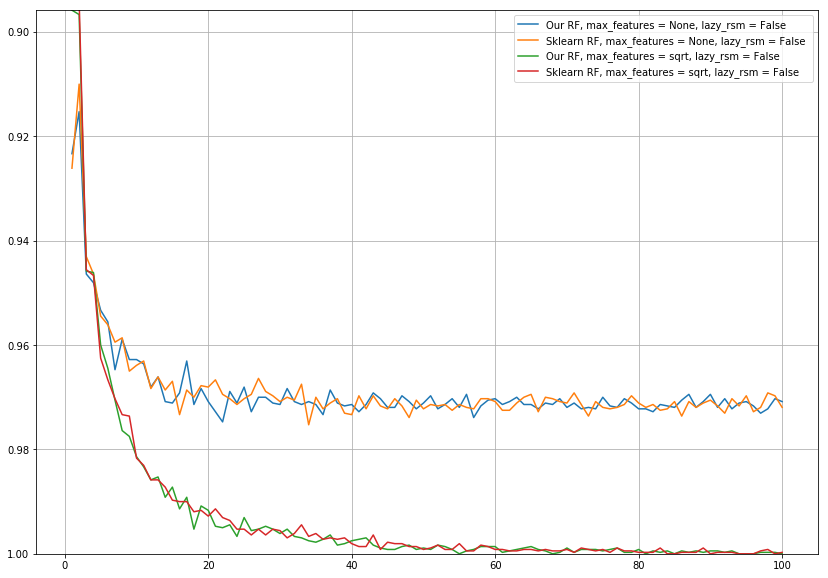

In [169]:
plt.figure(figsize=(14, 10))
grid_length = 100
plot_comparsion(None, grid_length)
plot_comparsion("sqrt", grid_length)
plt.grid()
plt.show()

**Комментарий:** Следов переобучения не видно, более того, алгоритм работает по качеству также, как и лес из sklearn, а по времени даже быстрее.

### Модификация Random Forest (15%)

Измените свою реализацию `RandomForest` так, чтобы случайное подмножество признаков выбиралось не в каждом сплите, а перед построением всего дерева. Сравните результат работы с обычным RandomForest.

In [170]:
rf = RandomForest(50, max_features="sqrt")
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

1.0

In [171]:
rf = RandomForest(50, lazy_rsm=True, max_features="sqrt")
rf.fit(X_train, y_train)
accuracy_score(rf.predict(X_test), y_test)

0.9722222222222222

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

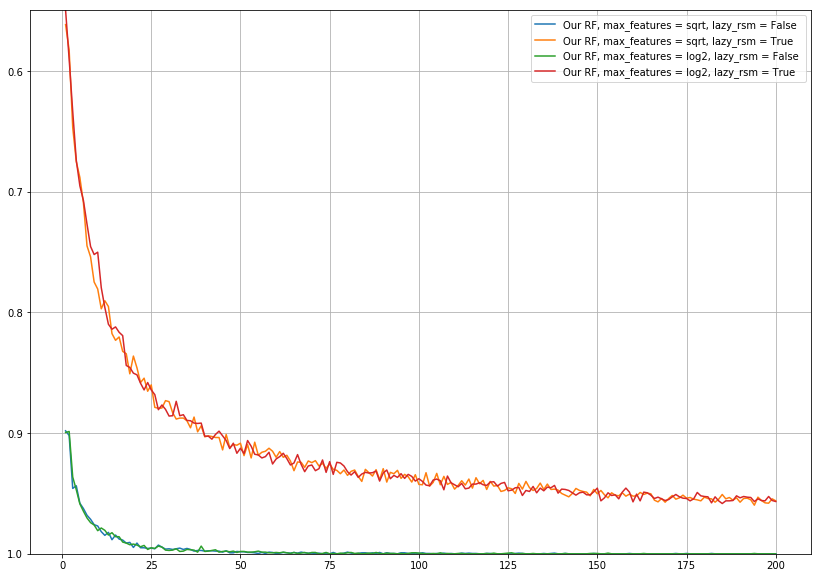

In [182]:
plt.figure(figsize=(14, 10))
grid_length = 200
runs = 100
plot_comparsion("sqrt", grid_length, runs=runs, lazy_rsm=False, run_sklearn=False)
plot_comparsion("sqrt", grid_length, runs=runs, lazy_rsm=True, run_sklearn=False)
plot_comparsion("log2", grid_length, runs=runs, lazy_rsm=False, run_sklearn=False)
plot_comparsion("log2", grid_length, runs=runs, lazy_rsm=True, run_sklearn=False)
plt.grid()
plt.show()

**Комментарий:** Качество существенно упало, что было ожидаемо. При этом похоже, что упала не скорость сходимости, а именно качество.